# Paper Soccer Demo Notebook

This notebook shows how to interact with environment that simulates playing in paper soccer.

There are three concepts to get familiar with:

- **Board** - board class with methods to interact with environment; equipped with method to draw the board
- **SingleBlock** - internal structure that represents each building-block of soccer game (data is bit-encoded in single value sou if you want to interact with the raw data you should transform it to separate bits)
- **Actor** - Actors creater in actors.py show possible ways of interacting with the environment

In [1]:
# Notebook dependencies
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm_notebook as tqdm

# paper soccer library
from papersoccer_env import Board
from actors import RandomActor, GreedyActor, TryOnlyBestActor
from tournament import play_game,  play_tournament
from sequence import encode_moves, decode_moves

In [2]:
# Set local progress method
progress_method=lambda x:tqdm(x)

# Board object

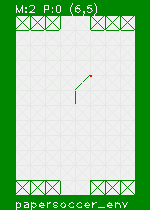

In [3]:
board = Board()
board.move("T")
board.move("TR")
Image.fromarray(board.draw())

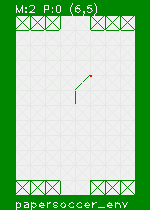

In [4]:
# copy board, changing source deos not change copy
board2 = board.copy()
board.move("T")
Image.fromarray(board2.draw())

moves made:1, valid_move=True, next_player=1, winner=None
moves made:2, valid_move=True, next_player=0, winner=None
moves made:3, valid_move=True, next_player=1, winner=None
moves made:4, valid_move=True, next_player=0, winner=None
moves made:5, valid_move=True, next_player=1, winner=None
moves made:5, valid_move=True, next_player=None, winner=0


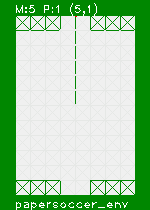

In [5]:
# move - returned values
board = Board()

move_code = "T"

valid_move, next_player, winner = board.move(move_code)
print(f"moves made:{board.moves}, valid_move={valid_move}, next_player={next_player}, winner={winner}")
valid_move, next_player, winner = board.move(move_code)
print(f"moves made:{board.moves}, valid_move={valid_move}, next_player={next_player}, winner={winner}")
valid_move, next_player, winner = board.move(move_code)
print(f"moves made:{board.moves}, valid_move={valid_move}, next_player={next_player}, winner={winner}")
valid_move, next_player, winner = board.move(move_code)
print(f"moves made:{board.moves}, valid_move={valid_move}, next_player={next_player}, winner={winner}")
valid_move, next_player, winner = board.move(move_code)
print(f"moves made:{board.moves}, valid_move={valid_move}, next_player={next_player}, winner={winner}")
valid_move, next_player, winner = board.move("T")
print(f"moves made:{board.moves}, valid_move={valid_move}, next_player={next_player}, winner={winner}")

Image.fromarray(board.draw())

# Drawing game via sequence of moves

In [6]:
_,img,img_game = Board.play_sequence(["T","TL","TR","R","B","L","BR","BL"])

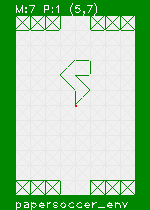

In [7]:
Image.fromarray(img)

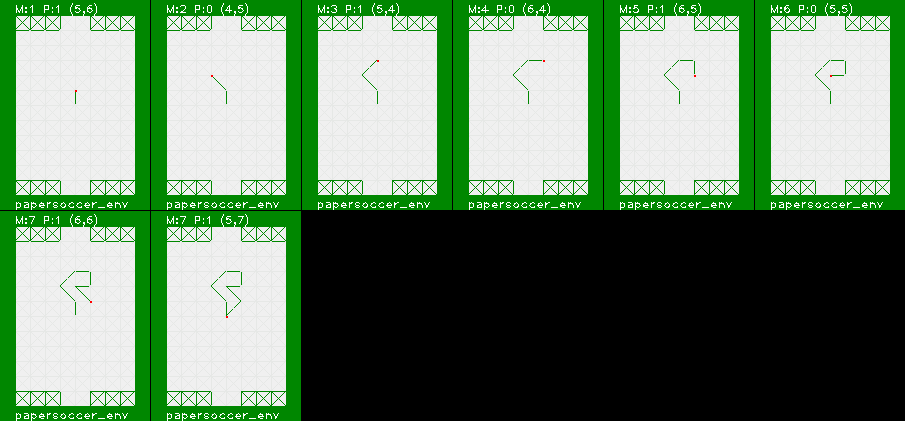

In [8]:
Image.fromarray(img_game)

# Representing the state

In [9]:
# board data state - compact
board,_,_ = Board.play_sequence(["T","TL","TR","R","B","L","BR","BL"])
board.get_compact_state()

'30,30,30,30,30,30,30,30,30,30,30,30,30,30,6,2,30,30,30,30,30,6,2,2,0,0,2,2,2,30,30,4,0,0,0,0,0,0,0,30,30,4,0,0,8,2,4,0,0,30,30,4,0,0,16,18,0,0,0,30,30,4,0,0,0,12,0,0,0,30,30,4,0,0,0,1,0,0,0,30,30,4,0,0,0,0,0,0,0,30,30,4,0,0,0,0,0,0,0,30,30,4,0,0,0,0,0,0,0,30,30,4,0,0,0,0,0,0,0,30,30,30,30,30,4,0,30,30,30,30,30,30,30,30,30,30,30,30,30,30'

In [17]:
# board data state - binary representation
board,_,_ = Board.play_sequence(["T","TL","TR","R","B","L","BR","BL"])
board.get_binary_state()

array([0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0,
       0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0,

In [11]:
# board data state - base64 state
board,_,_ = Board.play_sequence(["T","TL","TR","R","B","L","BR","BL"])
board.get_b64_state()

'Hh4eHh4eHh4eHh4eHh4GAh4eHh4eBgICAAACAgIeHgQAAAAAAAAAHh4EAAAIAgQAAB4eBAAAEBIAAAAeHgQAAAAMAAAAHh4EAAAAAQAAAB4eBAAAAAAAAAAeHgQAAAAAAAAAHh4EAAAAAAAAAB4eBAAAAAAAAAAeHh4eHgQAHh4eHh4eHh4eHh4eHh4='

In [12]:
# Move sequence representation
_, _, sequence, _ = play_game(RandomActor("1"), RandomActor("2"), max_moves=10)
print("Sequence        :", sequence)
print("Sequence length :", len(sequence))
encoded = encode_moves(sequence)
print("Encoded         :", encoded)
print("Decoded         :", decode_moves(encoded))

Sequence        : ['BL', 'T', 'T', 'T', 'R', 'TR', 'T', 'L', 'TL', 'TR']
Sequence length : 10
Encoded         : dkhUwQA=
Decoded         : ['BL', 'T', 'T', 'T', 'R', 'TR', 'T', 'L', 'TL', 'TR']


# Playing with the environment

actors.py file below shows how to approach implementation of an actor (those are really silly ones).
Basically there in only one methods to be implemented:
* move

Method of moving takes environment as a parameter. Environment variables are accessible so you can get **environment state**. Environment has methods to support takieng **actions**:
- possible_moves(...) - returns a list of possible moves
- move(...) - performs a move, returns information if move was valid, who is nest to play and if anybody has already won

## Random play

In [13]:
points, history  = play_tournament([RandomActor("1"),RandomActor("2"),RandomActor("3")])

# Returns points after tournament (1-win; 0-loss; 0.5-draw)
points

{'Random_1': 191, 'Random_2': 206, 'Random_3': 203}

### Stats of the game lengths

Average game length 37.655
Median game length 31.0
Min game length 5
Max game length 172


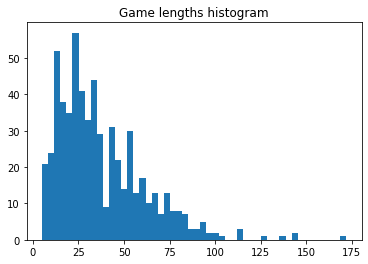

In [14]:
lengths = [len(h[3]) for h in history]
print("Average game length",np.mean(lengths))
print("Median game length",np.median(lengths))
print("Min game length",np.min([lengths]))
print("Max game length",np.max([lengths]))

plt.hist(lengths, bins=50)
plt.title("Game lengths histogram")
del history

# Combined tournament

In [15]:
# One of each
points, _  = play_tournament([RandomActor("1"),GreedyActor("2"),TryOnlyBestActor("3")], 
                             rounds=1000, progress_lambda=progress_method)

# Returns points after tournament (1-win; 0-loss; 0.5-draw)
points

{'Random_1': 1057, 'Greedy_2': 3240, 'TryBest_3': 1703}

In [16]:
# Two of each
points, _  = play_tournament([RandomActor("1"),GreedyActor("2"),TryOnlyBestActor("3"),
                              RandomActor("4"),GreedyActor("5"),TryOnlyBestActor("6")], 
                               rounds=1000,progress_lambda=progress_method)

# Returns points after tournament (1-win; 0-loss; 0.5-draw)
points

{'Random_1': 3095,
 'Greedy_2': 7501,
 'TryBest_3': 4363,
 'Random_4': 3145,
 'Greedy_5': 7534,
 'TryBest_6': 4362}